
### **k means clustering**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report
from scipy.stats import mode
data_csv = '/data.csv'
labels_csv = '/labels.csv'

# Load the data
data_df = pd.read_csv(data_csv)
labels_df = pd.read_csv(labels_csv)

# Merge the data on Sample ID
merged_df = pd.merge(data_df, labels_df, left_on='Unnamed: 0', right_on='Unnamed: 0')

# Drop unnecessary columns
X = merged_df.drop(['Unnamed: 0', 'Stage'], axis=1, errors='ignore')
y_class = merged_df['Class']

# Convert all columns to numeric, replacing non-convertible values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean of the column
X.fillna(X.mean(), inplace=True)

# Encode the target variable if it's not numeric
if y_class.dtype == 'object':
    y_class = LabelEncoder().fit_transform(y_class)

# Ensure there are no NaNs or infinite values in the scaled data
X.replace([np.inf, -np.inf], np.nan, inplace=True)
# Check if dropping all NaNs results in an empty DataFrame
if X.dropna().shape[0] == 0:
    print("Warning: Dropping all NaNs results in an empty DataFrame. Consider alternative handling of missing values.")
    # Handle the situation appropriately, e.g., impute with a constant value instead of mean
    X.fillna(0, inplace=True)  # Example: Fill NaNs with 0
else:
    X.dropna(inplace=True)

# Align y_class with X after removing NaN rows from X
y_class = y_class[X.index]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class)

# Train K-Means clustering
kmeans = KMeans(n_clusters=len(np.unique(y_class)), random_state=42)
kmeans.fit(X_train)

# Predict the cluster for each instance in the training data
train_clusters = kmeans.predict(X_train)

# Map each cluster to the most frequent class in that cluster
cluster_class_map = {}
for cluster in np.unique(train_clusters):
    mask = (train_clusters == cluster)
    # Handle the case where mode returns a single value
    mode_result = mode(y_train[mask])
    # Access mode and count as attributes, not as indices
    cluster_class_map[cluster] = mode_result.mode if mode_result.count > 0 else None  # Assign None if no mode

# Predict the cluster for each instance in the test data
test_clusters = kmeans.predict(X_test)

# Map the clusters to the predicted classes using the cluster to class mapping
# Handle potential None values in the cluster_class_map
y_pred = np.array([cluster_class_map.get(cluster, -1) for cluster in test_clusters])  # Assign -1 for clusters without a mapped class

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred) * 100  # Calculate accuracy and multiply by 100
print("K-Means Clustering Accuracy: {:.2f}%".format(accuracy))  # Format as percentage
print("Classification Report:\n", classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


K-Means Clustering Accuracy: 93.18%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90        34
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        16
           3       0.94      1.00      0.97        15
           4       0.75      1.00      0.86        15

    accuracy                           0.93        88
   macro avg       0.94      0.96      0.95        88
weighted avg       0.95      0.93      0.93        88



**Long Short-Term Memory Networks (LSTMs)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Load the data
data_csv = '/data.csv'
labels_csv = '/labels.csv'

data_df = pd.read_csv(data_csv)
labels_df = pd.read_csv(labels_csv)

# Merge the data on Sample ID
merged_df = pd.merge(data_df, labels_df, left_on='Unnamed: 0', right_on='Unnamed: 0')

# Drop unnecessary columns
X = merged_df.drop(['Unnamed: 0', 'Stage'], axis=1, errors='ignore')
y_class = merged_df['Class']

# Convert all columns to numeric, replacing non-convertible values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Instead of filling NaNs, drop columns with a high proportion of missing values
threshold = 0.8 # Set a threshold for dropping columns
X = X.dropna(thresh=len(X) * (1 - threshold), axis=1) # Drop columns with more than 80% missing values
X.fillna(X.mean(), inplace=True) # Fill the remaining missing values with the mean

# Encode the target variable if it's not numeric
if y_class.dtype == 'object':
    y_class = LabelEncoder().fit_transform(y_class)

# Ensure there are no NaNs or infinite values in the scaled data
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
X.dropna(inplace=True)

# Align y_class with X after removing NaN rows from X
y_class = y_class[X.index]

# Check if X is empty after dropping rows
if X.empty:
    raise ValueError("X is empty after dropping rows with missing values. Check your data and preprocessing steps.")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data to fit LSTM input requirements
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# One-hot encode the target variable
y_class = to_categorical(y_class)

# Use stratified k-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  # Increase the number of folds to 10
accuracies = []

for train_index, test_index in kf.split(X_scaled, np.argmax(y_class, axis=1)):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_class[train_index], y_class[test_index]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(10, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))  # Reduce number of units
    model.add(Dropout(0.3))  # Increase dropout rate
    model.add(LSTM(10))  # Reduce number of units
    model.add(Dropout(0.3))  # Increase dropout rate
    model.add(Dense(y_class.shape[1], activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Implement early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.3, verbose=0, callbacks=[early_stopping])  # Increase validation split to 0.3 and reduce epochs to 20

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    accuracies.append(accuracy)
    print("Fold Accuracy: {:.2f}%".format(accuracy * 100))
    print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

# Calculate and print the mean accuracy across folds
mean_accuracy = np.mean(accuracies)
print("Mean LSTM Accuracy: {:.2f}%".format(mean_accuracy * 100))


3/3 [==============================] - 1s 6ms/step
Fold Accuracy: 97.40%
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        29
           1       1.00      0.86      0.92         7
           2       0.93      0.93      0.93        14
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        14

    accuracy                           0.97        77
   macro avg       0.98      0.96      0.97        77
weighted avg       0.97      0.97      0.97        77

3/3 [==============================] - 1s 6ms/step
Fold Accuracy: 98.70%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98        29
           1       0.88      1.00      0.93         7
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3/3 [==============================] - 1s 6ms/step
Fold Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00        13

    accuracy                           1.00        77
   macro avg       1.00      1.00      1.00        77
weighted avg       1.00      1.00      1.00        77

3/3 [==============================] - 1s 6ms/step
Fold Accuracy: 98.70%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       1.00      0.88      0.93         8
           2       0.93      1.00      0.97        14
           3       1.00      1.00      1.00        13
           4       1.00      1.00      1.00  

**LASSO REGRESSION ALGORITHM**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Load the data
data_df = pd.read_csv('/data.csv')
labels_df = pd.read_csv('/labels.csv')

# Print the columns of both dataframes to identify the correct key for merging
print("Columns in data_df:", data_df.columns)
print("Columns in labels_df:", labels_df.columns)

# Merge the dataframes on the common column
df = pd.merge(data_df, labels_df, on='Unnamed: 0')

# Separate features and labels
X = df.drop(columns=['Unnamed: 0', 'Class'])  # Adjust column names if necessary
y = df['Class']  # Adjust column name if necessary

# Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.4, random_state=42, stratify=y_encoded)  # Use larger test set

# Create a pipeline for preprocessing and feature selection
model_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Fit the pipeline to the training data and transform both training and test data
X_train_transformed = model_pipeline.fit_transform(X_train, y_train)
X_test_transformed = model_pipeline.transform(X_test)  # Transform the test data using the same pipeline

# Perform feature selection using Lasso with cross-validation to select alpha
lasso = Lasso(alpha=0.5)  # Increased alpha for more regularization
lasso.fit(X_train_transformed, y_train)

# Identify selected features
selected_features_indices = lasso.coef_ != 0

# Define the models to compare
models = {
    'LogisticRegression': OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    'RandomForestClassifier': OneVsRestClassifier(RandomForestClassifier()) # Wrap RandomForestClassifier in OneVsRestClassifier
}

# Define parameter grids for hyperparameter tuning
# Use 'estimator__' prefix to tune parameters within OneVsRestClassifier
param_grids = {
    'LogisticRegression': {
        'estimator__C': [0.1, 1, 10],
        'estimator__solver': ['liblinear', 'saga']
    },
    'RandomForestClassifier': {
        'estimator__n_estimators': [50, 100, 150],
        'estimator__max_depth': [10, 20, 30],
        'estimator__min_samples_split': [2, 5, 10]
    }
}

# Perform cross-validation and hyperparameter tuning
for model_name, model in models.items():
    print(f"\nTuning hyperparameters for {model_name}...")

    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, n_jobs=-1)
    grid_search.fit(X_train_transformed[:, selected_features_indices], y_train)

    best_model = grid_search.best_estimator_
# Cross-validation score to check generalization
    cv_scores = cross_val_score(best_model, X_train_transformed[:, selected_features_indices], y_train, cv=5, n_jobs=-1)
    print(f"Cross-validation scores for {model_name}: {cv_scores}")
    print(f"Mean cross-validation score: {np.mean(cv_scores) * 100:.2f}%")

    # Predict on the test set using the best model
    y_pred = best_model.predict(X_test_transformed[:, selected_features_indices])

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy for {model_name}: {accuracy * 100:.2f}%')

    # Print the classification report
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

    # Get the names of selected features (adjust based on how you access column names after transformation)
    selected_features = X.columns[selected_features_indices]
    print(f"Selected Features for {model_name}:\n", selected_features)


Columns in data_df: Index(['Unnamed: 0', 'gene_0', 'gene_1', 'gene_2', 'gene_3', 'gene_4',
       'gene_5', 'gene_6', 'gene_7', 'gene_8',
       ...
       'gene_20521', 'gene_20522', 'gene_20523', 'gene_20524', 'gene_20525',
       'gene_20526', 'gene_20527', 'gene_20528', 'gene_20529', 'gene_20530'],
      dtype='object', length=20532)
Columns in labels_df: Index(['Unnamed: 0', 'Class'], dtype='object')

Tuning hyperparameters for LogisticRegression...


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Cross-validation scores for LogisticRegression: [0.97916667 0.96875    0.97916667 0.97916667 0.98958333]
Mean cross-validation score: 97.92%
Accuracy for LogisticRegression: 96.26%
Classification Report for LogisticRegression:
               precision    recall  f1-score   support

        BRCA       0.98      1.00      0.99       120
        COAD       0.96      0.87      0.92        31
        KIRC       0.90      0.97      0.93        59
        LUAD       0.96      0.91      0.94        57
        PRAD       0.98      0.98      0.98        54

    accuracy                           0.96       321
   macro avg       0.96      0.95      0.95       321
weighted avg       0.96      0.96      0.96       321

Selected Features for LogisticRegression:
 Index(['gene_89', 'gene_1750', 'gene_3448', 'gene_5578', 'gene_14092',
       'gene_16372', 'gene_16987', 'gene_17801', 'gene_18745', 'gene_19339'],
      dtype='object')

Tuning hyperparameters for RandomForestClassifier...
Cross-validatio

**Gradient Vector Boosting**

In [ ]:
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif

# Suppress warnings
warnings.filterwarnings('ignore')

# Load the data
data_csv = '/data.csv'
labels_csv = '/labels.csv'

data_df = pd.read_csv(data_csv)
labels_df = pd.read_csv(labels_csv)

# Merge the data on Sample ID
merged_df = pd.merge(data_df, labels_df, left_on='Unnamed: 0', right_on='Unnamed: 0')

# Drop unnecessary columns
X = merged_df.drop(['Unnamed: 0', 'Stage'], axis=1, errors='ignore')
y_class = merged_df['Class']

# Convert all columns to numeric, replacing non-convertible values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Instead of filling NaNs, drop columns with a high proportion of missing values
threshold = 0.8  # Set a threshold for dropping columns
X = X.dropna(thresh=len(X) * (1 - threshold), axis=1)  # Drop columns with more than 80% missing values
X.fillna(X.mean(), inplace=True)  # Fill the remaining missing values with the mean

# Encode the target variable if it's not numeric
if y_class.dtype == 'object':
    y_class = LabelEncoder().fit_transform(y_class)

# Ensure there are no NaNs or infinite values in the scaled data
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
X.dropna(inplace=True)
# Align y_class with X after removing NaN rows from X
y_class = y_class[X.index]
# Check if X is empty after dropping rows
if X.empty:
    raise ValueError("X is empty after dropping rows with missing values. Check your data and preprocessing steps.")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection to reduce the number of features
num_features = 100  # Adjust based on your needs
selector = SelectKBest(f_classif, k=num_features)
X_selected = selector.fit_transform(X_scaled, y_class)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_class, test_size=0.2, stratify=y_class, random_state=42)

# Create the Gradient Boosting Classifier with optimized parameters for speed
gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, subsample=0.8, random_state=42)

# Train the model
gbc.fit(X_train, y_train)

# Make predictions
y_pred = gbc.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Gradient Boosting Classifier Accuracy: {:.2f}%".format(accuracy * 100))

# Get classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Gradient Boosting Classifier Accuracy: 98.14%
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      0.94      0.97        16
           2       0.97      1.00      0.98        30
           3       1.00      0.93      0.96        28
           4       1.00      1.00      1.00        27

    accuracy                           0.98       161
   macro avg       0.99      0.97      0.98       161
weighted avg       0.98      0.98      0.98       161



**Ridge Logistic Regression**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

# Load the data
data_csv = '/data.csv'
labels_csv = '/labels.csv'

data_df = pd.read_csv(data_csv)
labels_df = pd.read_csv(labels_csv)

# Merge the data on Sample ID
merged_df = pd.merge(data_df, labels_df, left_on='Unnamed: 0', right_on='Unnamed: 0')

# Drop unnecessary columns
X = merged_df.drop(['Unnamed: 0', 'Stage'], axis=1, errors='ignore')
y_class = merged_df['Class']

# Convert all columns to numeric, replacing non-convertible values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Instead of filling NaNs, drop columns with a high proportion of missing values
threshold = 0.8  # Set a threshold for dropping columns
X = X.dropna(thresh=len(X) * (1 - threshold), axis=1)  # Drop columns with more than 80% missing values
X.fillna(X.mean(), inplace=True)  # Fill the remaining missing values with the mean

# Encode the target variable if it's not numeric
if y_class.dtype == 'object':
    y_class = LabelEncoder().fit_transform(y_class)

# Ensure there are no NaNs or infinite values in the scaled data
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values
X.dropna(inplace=True)

# Align y_class with X after removing NaN rows from X
y_class = y_class[X.index]

# Check if X is empty after dropping rows
if X.empty:
    raise ValueError("X is empty after dropping rows with missing values. Check your data and preprocessing steps.")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection to reduce the number of features
num_features = 100  # Adjust based on your needs
selector = SelectKBest(f_classif, k=num_features)
X_selected = selector.fit_transform(X_scaled, y_class)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_class, test_size=0.2, stratify=y_class, random_state=42)

# Create the Ridge Logistic Regression model
ridge_lr = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000, random_state=42)

# Train the model
ridge_lr.fit(X_train, y_train)

# Make predictions
y_pred = ridge_lr.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Ridge Logistic Regression Accuracy: {:.2f}%".format(accuracy * 100))

# Get classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)


Ridge Logistic Regression Accuracy: 98.76%
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        30
           3       1.00      0.93      0.96        28
           4       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       0.99      0.99      0.99       161
weighted avg       0.99      0.99      0.99       161



**Restricted Boltzmann Machine (RBM)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load the data
data_csv = '/data.csv'
labels_csv = '/labels.csv'

data_df = pd.read_csv(data_csv)
labels_df = pd.read_csv(labels_csv)

# Merge the data on Sample ID
merged_df = pd.merge(data_df, labels_df, left_on='Unnamed: 0', right_on='Unnamed: 0')

# Drop unnecessary columns
X = merged_df.drop(['Unnamed: 0', 'Stage'], axis=1, errors='ignore')
y_class = merged_df['Class']

# Convert all columns to numeric, replacing non-convertible values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean of the column
X.fillna(X.mean(), inplace=True)

# Encode the target variable if it's not numeric
if y_class.dtype == 'object':
    y_class = LabelEncoder().fit_transform(y_class)

# Ensure there are no NaNs or infinite values in the scaled data
X.replace([np.inf, -np.inf], np.nan, inplace=True)
# Check if dropping all NaNs results in an empty DataFrame
if X.dropna().shape[0] == 0:
    print("Warning: Dropping all NaNs results in an empty DataFrame. Consider alternative handling of missing values.")
    # Handle the situation appropriately, e.g., impute with a constant value instead of mean
    X.fillna(0, inplace=True)  # Example: Fill NaNs with 0
else:
    X.dropna(inplace=True)

# Align y_class with X after removing NaN rows from X
y_class = y_class[X.index]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class)

# Train the RBM and Logistic Regression pipeline
rbm = BernoulliRBM(random_state=42, n_iter=10, n_components=100)
logistic = LogisticRegression(max_iter=10000, solver='lbfgs')
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

classifier.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("RBM + Logistic Regression Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report:\n", classification_report(y_test, y_pred))


RBM + Logistic Regression Accuracy: 92.86%
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92        31
           1       0.80      1.00      0.89         8
           2       0.94      1.00      0.97        15
           3       1.00      0.87      0.93        15
           4       0.93      0.93      0.93        15

    accuracy                           0.93        84
   macro avg       0.92      0.94      0.93        84
weighted avg       0.93      0.93      0.93        84



**Generative Adversarial Networks (GANs) augmented data**

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# Load the data
data_csv = '/data.csv'
labels_csv = '/labels.csv'

data_df = pd.read_csv(data_csv)
labels_df = pd.read_csv(labels_csv)

# Merge the data on Sample ID
merged_df = pd.merge(data_df, labels_df, left_on='Unnamed: 0', right_on='Unnamed: 0')

# Drop unnecessary columns
X = merged_df.drop(['Unnamed: 0', 'Stage'], axis=1, errors='ignore')
y_class = merged_df['Class']

# Convert all columns to numeric, replacing non-convertible values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean of the column
X.fillna(X.mean(), inplace=True)

# Encode the target variable if it's not numeric
if y_class.dtype == 'object':
    y_class = LabelEncoder().fit_transform(y_class)

# Ensure there are no NaNs or infinite values in the scaled data
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(0, inplace=True)  # Fill remaining NaNs with 0

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class)

# Define the GAN
def build_generator(latent_dim, n_outputs):
    model = models.Sequential()
    model.add(layers.Dense(64, input_dim=latent_dim))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(n_outputs, activation='tanh'))
    return model

def build_discriminator(n_inputs):
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=n_inputs))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

latent_dim = 100
n_outputs = X_train.shape[1]

generator = build_generator(latent_dim, n_outputs)
discriminator = build_discriminator(n_outputs)
gan = build_gan(generator, discriminator)

# Train the GAN
def train_gan(gan, generator, discriminator, X_train, epochs=100, batch_size=64):
    half_batch = int(batch_size / 2)
    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        real_samples = X_train[idx]

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        gen_samples = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_samples, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_samples, np.zeros((half_batch, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.array([1] * batch_size)
        g_loss = gan.train_on_batch(noise, valid_y)

train_gan(gan, generator, discriminator, X_train)

# Generate synthetic data
noise = np.random.normal(0, 1, (X_train.shape[0], latent_dim))
gen_samples = generator.predict(noise)

# Combine synthetic and real data
X_augmented = np.vstack((X_train, gen_samples))
y_augmented = np.hstack((y_train, y_train))  # Duplicate labels for synthetic data

# Train a classifier on the augmented dataset
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_augmented, y_augmented)

# Predict and evaluate the classifier
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Classifier Accuracy with GAN-Augmented Data: {:.2f}%".format(accuracy * 100))
print("Classification Report:\n", classification_report(y_test, y_pred))


20/20 [==============================] - 0s 14ms/step
Random Forest Classifier Accuracy with GAN-Augmented Data: 98.76%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00        30
           3       0.96      0.96      0.96        28
           4       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       0.99      0.98      0.98       161
weighted avg       0.99      0.99      0.99       161



**ANN Classifier**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

data_csv = '/data.csv'
labels_csv = '/labels.csv'

# Load the data
data_df = pd.read_csv(data_csv)
labels_df = pd.read_csv(labels_csv)

# Merge the data on Sample ID
merged_df = pd.merge(data_df, labels_df, left_on='Unnamed: 0', right_on='Unnamed: 0')

# Drop unnecessary columns
X = merged_df.drop(['Unnamed: 0', 'Stage'], axis=1, errors='ignore')
y_class = merged_df['Class']

# Convert all columns to numeric, replacing non-convertible values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean of the column
X.fillna(X.mean(), inplace=True)

# Encode the target variable if it's not numeric
if y_class.dtype == 'object':
    y_class = LabelEncoder().fit_transform(y_class)

# Ensure there are no NaNs or infinite values in the scaled data
X.replace([np.inf, -np.inf], np.nan, inplace=True)
if X.dropna().shape[0] == 0:
    print("Warning: Dropping all NaNs results in an empty DataFrame. Consider alternative handling of missing values.")
    X.fillna(0, inplace=True)
else:
    X.dropna(inplace=True)

# Align y_class with X after removing NaN rows from X
y_class = y_class[X.index]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert labels to categorical
y_categorical = to_categorical(y_class)

# Define cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = []
for train_index, test_index in kfold.split(X_scaled, y_class):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y_categorical[train_index], y_categorical[test_index]

    # Define the model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))
    model.add(Dense(len(np.unique(y_class)), activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

    # Evaluate the model
    y_pred_categorical = model.predict(X_test)
    y_pred = np.argmax(y_pred_categorical, axis=1)
    y_test_class = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_class, y_pred) * 100
    accuracies.append(accuracy)
    print("Fold Accuracy: {:.2f}%".format(accuracy))
    print("Classification Report:\n", classification_report(y_test_class, y_pred))

print("Average Accuracy: {:.2f}%".format(np.mean(accuracies)))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Fold Accuracy: 97.73%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       1.00      1.00      1.00         2
           2       0.89      1.00      0.94         8
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         9

    accuracy                           0.98        44
   macro avg       0.98      0.99      0.98        44
weighted avg       0.98      0.98      0.98        44



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Fold Accuracy: 95.45%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.88      0.94        17
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       0.80      1.00      0.89         8
           4       1.00      1.00      1.00         9

    accuracy                           0.95        44
   macro avg       0.96      0.98      0.97        44
weighted avg       0.96      0.95      0.96        44



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Fold Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         9

    accuracy                           1.00        44
   macro avg       1.00      1.00      1.00        44
weighted avg       1.00      1.00      1.00        44



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Fold Accuracy: 95.45%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.75      1.00      0.86         3
           2       0.89      1.00      0.94         8
           3       1.00      0.78      0.88         9
           4       1.00      1.00      1.00         8

    accuracy                           0.95        44
   macro avg       0.93      0.96      0.93        44
weighted avg       0.96      0.95      0.95        44



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Fold Accuracy: 95.45%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.60      1.00      0.75         3
           2       1.00      1.00      1.00         8
           3       1.00      0.78      0.88         9
           4       1.00      1.00      1.00         8

    accuracy                           0.95        44
   macro avg       0.92      0.96      0.93        44
weighted avg       0.97      0.95      0.96        44

Average Accuracy: 96.82%


**Naive bayesian**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif

data_csv = '/data.csv'
labels_csv = '/labels.csv'

# Load the data
data_df = pd.read_csv(data_csv)
labels_df = pd.read_csv(labels_csv)

# Merge the data on Sample ID
merged_df = pd.merge(data_df, labels_df, left_on='Unnamed: 0', right_on='Unnamed: 0')

# Drop unnecessary columns
X = merged_df.drop(['Unnamed: 0', 'Stage'], axis=1, errors='ignore')
y_class = merged_df['Class']

# Convert all columns to numeric, replacing non-convertible values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean of the column
X.fillna(X.mean(), inplace=True)

# Encode the target variable if it's not numeric
if y_class.dtype == 'object':
    y_class = LabelEncoder().fit_transform(y_class)

# Ensure there are no NaNs or infinite values in the scaled data
X.replace([np.inf, -np.inf], np.nan, inplace=True)
if X.dropna().shape[0] == 0:
    print("Warning: Dropping all NaNs results in an empty DataFrame. Consider alternative handling of missing values.")
    X.fillna(0, inplace=True)
else:
    X.dropna(inplace=True)

# Align y_class with X after removing NaN rows from X
y_class = y_class[X.index]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection: Select the top 50 features
selector = SelectKBest(f_classif, k=50)
X_selected = selector.fit_transform(X_scaled, y_class)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_class, test_size=0.2, random_state=42, stratify=y_class)

# Initialize the Naive Bayes classifier
nb_model = GaussianNB()

# Train the model
nb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = nb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred) * 100
print("Naive Bayes Model Accuracy: {:.2f}%".format(accuracy))
print("Classification Report:\n", classification_report(y_test, y_pred))

Naive Bayes Model Accuracy: 97.73%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.67      0.80         3
           2       1.00      1.00      1.00         7
           3       0.90      1.00      0.95         9
           4       1.00      1.00      1.00         9

    accuracy                           0.98        44
   macro avg       0.98      0.93      0.95        44
weighted avg       0.98      0.98      0.98        44



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    5    23  1624  1749  1765  3527  4370  4374  4375  4376  4639  4808
  4809  4810  4814  4815  4816  4817  4818  4819  4823  4828  4829  4831
  4834  5288  6191  6697  6804  7262  7661  7662  7663  7664  7665  8121
  9299  9304  9306  9314  9315  9316  9320  9321  9323  9350  9351  9452
  9744 10121 10139 11958 12360 12373 12383 12384 12387 12403 12489 12490
 12519 12522 12557 12614 12619 12628 12629 12634 12635 12644 12645 12648
 12664 12672 12674 12682 12689 12718 12719 12721 12724 13777 13860 13991
 14158 14159 14161 14448 14550 15138 15140 15141 15446 15554 15563 16566
 16568 16569 16571 16572 16573 16574 16575 16576 16577 16578 16579 16603
 16604 16634 16637 16677 16697 16698 16699 16700 16701 16702 16704 16705
 16706 16707 16708 16709 16710 16711 16712 16713 16714 16715 16716 16717
 16718 16719 16720 16721 16722 16723 16724 16725 16726 16727 16728 16729
 16730

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [    5    23  4370  4808  4809  4814  4816  4817  4831  5288  7661  7662
  7663  7664  7665  8121  9304  9306  9314  9316  9320  9452 10121 11958
 13991 14158 14159 14161 15138 15140 15141 15446 16566 16568 16569 16571
 16575 16578 16579 16604 16634 16637 16677 16697 16698 16699 16700 16701
 16702 16704 16705 16706 16707 16708 16709 16710 16711 16712 16713 16714
 16715 16716 16717 16718 16719 16720 16721 16722 16723 16724 16725 16726
 16727 16728 16729 16730 16731 16732 16733 16734 16735 16736 16737 16738
 16739 16740 16741 16742 16743 16744 16745 16746 16748 16749 16750 16751
 16752 16753 16754 16756 16757 16758 16759 16760 16761 16762 16763 16764
 16765 16766 16767 16768 16769 16770 16771 16772 16774 16775 16776 16777
 16778 16779 16780 16781 16782 16783 16785 16787 16788 16789 16790 16791
 16792 16794 16795 16796 16798 16799 16800 16801 16802 16803 16804 16805
 16806

Gradient Boosting Classifier Accuracy: 98.76%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      0.94      0.97        16
           2       0.97      1.00      0.98        30
           3       1.00      0.96      0.98        28
           4       1.00      1.00      1.00        27

    accuracy                           0.99       161
   macro avg       0.99      0.98      0.98       161
weighted avg       0.99      0.99      0.99       161



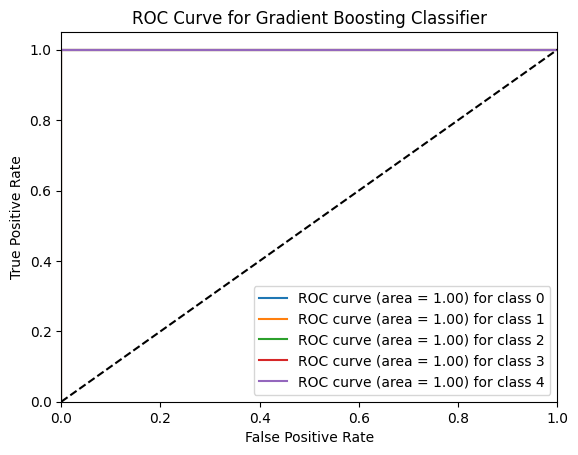

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load the data
data_csv = '/data.csv'  # Update path accordingly
labels_csv = '/labels.csv'  # Update path accordingly

data_df = pd.read_csv(data_csv)
labels_df = pd.read_csv(labels_csv)

# Merge the data on Sample ID
merged_df = pd.merge(data_df, labels_df, left_on='Unnamed: 0', right_on='Unnamed: 0')

# Drop unnecessary columns
X = merged_df.drop(['Unnamed: 0', 'Stage'], axis=1, errors='ignore')
y_class = merged_df['Class']

# Convert all columns to numeric, replacing non-convertible values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean of the column
X.fillna(X.mean(), inplace=True)

# Encode the target variable if it's not numeric
if y_class.dtype == 'object':
    y_class = LabelEncoder().fit_transform(y_class)

# Ensure there are no NaNs or infinite values in the scaled data
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle the situation appropriately
if X.dropna().shape[0] == 0:
    print("Warning: Dropping all NaNs results in an empty DataFrame. Consider alternative handling of missing values.")
    X.fillna(0, inplace=True)
else:
    X.dropna(inplace=True)

# Align y_class with X after removing NaN rows from X
y_class = y_class[X.index]

# Feature Selection: Select top 100 features based on ANOVA F-value
selector = SelectKBest(f_classif, k=100)
X_selected = selector.fit_transform(X, y_class)

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

try:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class
    )
except ValueError:
    print(
        "Warning: A class has only one sample. Stratified splitting is not possible."
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_class, test_size=0.2, random_state=42
    )  # Split without stratification

# Train Gradient Boosting Classifier with fewer estimators and max depth for quicker runtime
gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=2, subsample=0.8, random_state=42)
gbc.fit(X_train, y_train)

# Predict probabilities
y_pred_prob = gbc.predict_proba(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, gbc.predict(X_test))
print("Gradient Boosting Classifier Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report:\n", classification_report(y_test, gbc.predict(X_test)))

# Generate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
# Determine the number of classes based on the number of columns in y_pred_prob
n_classes = y_pred_prob.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting Classifier')
plt.legend(loc="lower right")
plt.show()


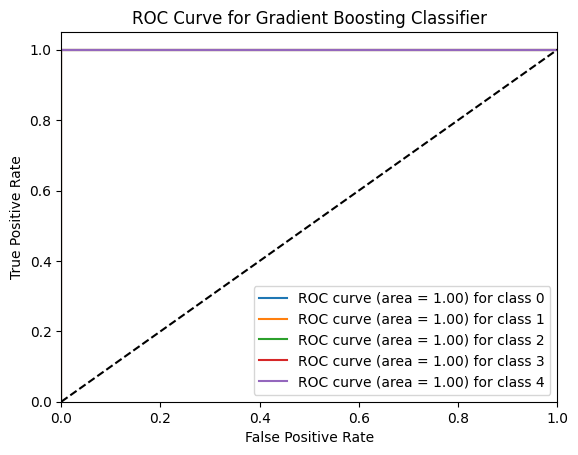

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_curve, auc, accuracy_score, classification_report
import matplotlib.pyplot as plt

# ... rest of your code ...

# Generate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
# Determine the number of classes based on the number of columns in y_pred_prob
n_classes = y_pred_prob.shape[1]

plt.figure()  # Create a new figure

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gradient Boosting Classifier')
plt.legend(loc="lower right")
plt.show()


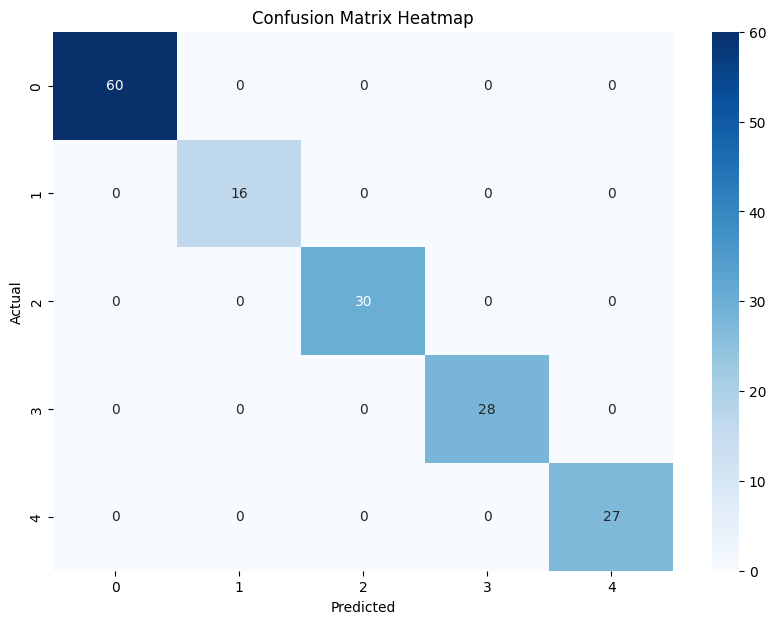

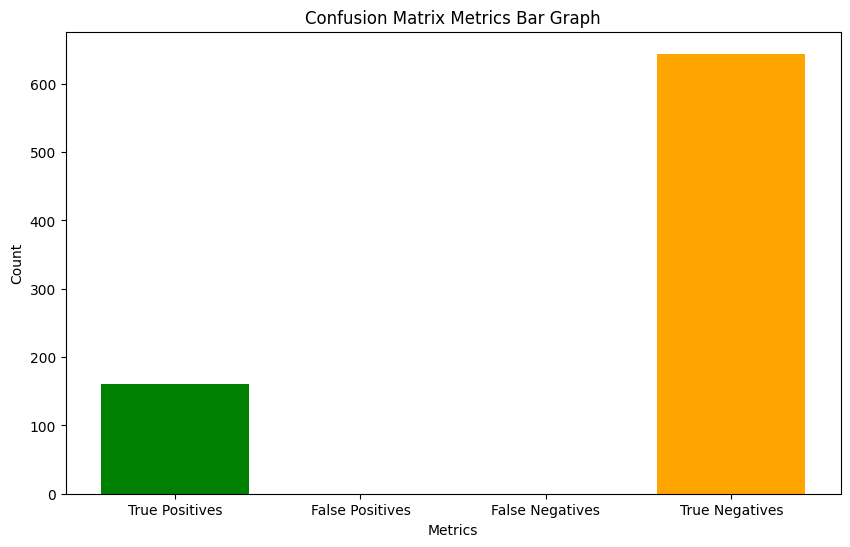

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data_csv = '/data.csv'  # Update path accordingly
labels_csv = '/labels.csv'  # Update path accordingly

data_df = pd.read_csv(data_csv)
labels_df = pd.read_csv(labels_csv)

# Merge the data on Sample ID
merged_df = pd.merge(data_df, labels_df, left_on='Unnamed: 0', right_on='Unnamed: 0')

# Drop unnecessary columns
X = merged_df.drop(['Unnamed: 0', 'Stage'], axis=1, errors='ignore')
y_class = merged_df['Class']

# Convert all columns to numeric, replacing non-convertible values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean of the column
X.fillna(X.mean(), inplace=True)

# Encode the target variable if it's not numeric
if y_class.dtype == 'object':
    y_class = LabelEncoder().fit_transform(y_class)

# Ensure there are no NaNs or infinite values in the scaled data
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle the situation appropriately
if X.dropna().shape[0] == 0:
    print("Warning: Dropping all NaNs results in an empty DataFrame. Consider alternative handling of missing values.")
    X.fillna(0, inplace=True)
else:
    X.dropna(inplace=True)

# Align y_class with X after removing NaN rows from X
y_class = y_class[X.index]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

try:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_class, test_size=0.2, random_state=42, stratify=y_class
    )
except ValueError:
    print(
        "Warning: A class has only one sample. Stratified splitting is not possible."
    )
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_class, test_size=0.2, random_state=42
    )  # Split without stratification

# Train Ridge Logistic Regression
ridge = RidgeClassifier()
ridge.fit(X_train, y_train)

# Predict the classes
y_pred = ridge.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as a bar graph
cm_df = pd.DataFrame(cm, index=np.unique(y_class), columns=np.unique(y_class))

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Plot confusion matrix bar graph
labels = ['True Positives', 'False Positives', 'False Negatives', 'True Negatives']
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp
tn = cm.sum() - (tp + fp + fn)

metrics = [tp.sum(), fp.sum(), fn.sum(), tn.sum()]

plt.figure(figsize=(10, 6))
plt.bar(labels, metrics, color=['green', 'red', 'blue', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Count')
plt.title('Confusion Matrix Metrics Bar Graph')
plt.show()


Cross-validated accuracy: 1.00 ± 0.00
Ridge Classifier Accuracy: 100.00%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        30
           3       1.00      1.00      1.00        28
           4       1.00      1.00      1.00        27

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



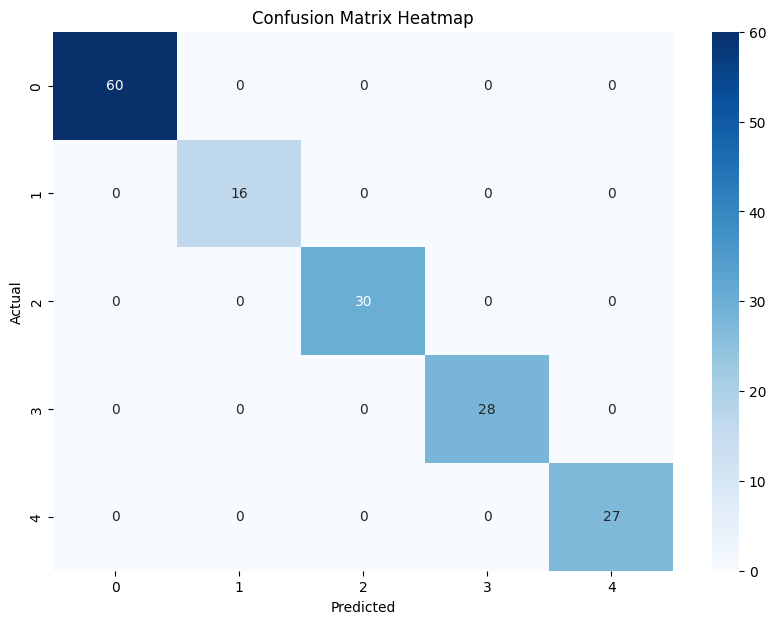

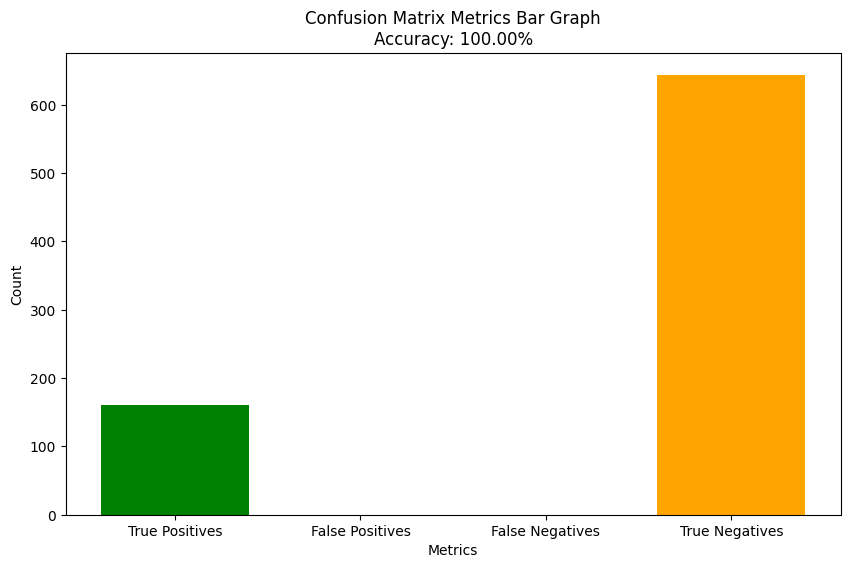

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data_csv = '/data.csv'  # Update path accordingly
labels_csv = '/labels.csv'  # Update path accordingly

data_df = pd.read_csv(data_csv)
labels_df = pd.read_csv(labels_csv)

# Merge the data on Sample ID
merged_df = pd.merge(data_df, labels_df, left_on='Unnamed: 0', right_on='Unnamed: 0')

# Drop unnecessary columns
X = merged_df.drop(['Unnamed: 0', 'Stage'], axis=1, errors='ignore')
y_class = merged_df['Class']

# Convert all columns to numeric, replacing non-convertible values with NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Fill missing values with the mean of the column
X.fillna(X.mean(), inplace=True)

# Encode the target variable if it's not numeric
if y_class.dtype == 'object':
    y_class = LabelEncoder().fit_transform(y_class)

# Ensure there are no NaNs or infinite values in the scaled data
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Handle the situation appropriately
if X.dropna().shape[0] == 0:
    print("Warning: Dropping all NaNs results in an empty DataFrame. Consider alternative handling of missing values.")
    X.fillna(0, inplace=True)
else:
    X.dropna(inplace=True)

# Align y_class with X after removing NaN rows from X
y_class = y_class[X.index]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=42, stratify=y_class)

# Standardize the data (fit on training data only, then transform both training and testing data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Ridge Logistic Regression
ridge = RidgeClassifier()

# Perform cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(ridge, X_train_scaled, y_train, cv=cv, scoring='accuracy')
print(f"Cross-validated accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# Fit the model on the full training data
ridge.fit(X_train_scaled, y_train)

# Predict the classes
y_pred = ridge.predict(X_test_scaled)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Ridge Classifier Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot confusion matrix as a heatmap
cm_df = pd.DataFrame(cm, index=np.unique(y_class), columns=np.unique(y_class))

plt.figure(figsize=(10, 7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Plot confusion matrix bar graph
labels = ['True Positives', 'False Positives', 'False Negatives', 'True Negatives']
tp = np.diag(cm)
fp = cm.sum(axis=0) - tp
fn = cm.sum(axis=1) - tp
tn = cm.sum() - (tp + fp + fn)

metrics = [tp.sum(), fp.sum(), fn.sum(), tn.sum()]

plt.figure(figsize=(10, 6))
plt.bar(labels, metrics, color=['green', 'red', 'blue', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Count')
plt.title('Confusion Matrix Metrics Bar Graph\nAccuracy: {:.2f}%'.format(accuracy * 100))
plt.show()
